# Random Forest Model on KKBox's Music Recommendation System 

In this notebook, we will fit a Random Forest model to the data, calculate the accuracies, run a grid search to extract the best model and build evaluation metrics to validate how well our model fits the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import re
import random
from sklearn import preprocessing
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from summary_fn import *

# 1. Loading data

In [2]:
# Import data 
data = pd.read_csv('features_train_data.csv')

In [3]:
# Display the transpose of the rows to visualize all columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, 
                           "display.max_columns", 1000): 
        display(df)

In [4]:
display_all(data.head().T)

,0,1,2,3,4
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=
source_system_tab,explore,my library,my library,my library,explore
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more,Explore
source_type,online-playlist,local-playlist,local-playlist,local-playlist,online-playlist
target,1,1,1,1,1
song_length,206471,284584,225396,255512,187802
artist_name,Bastille,Various Artists,Nas,Soundway,Brett Young
composer,Dan Smith| Mark Crew,NaN,N. Jones、W. Adams、J. Lordan、D. Ingle,Kwadwo Donkoh,Brett Young| Kelly Archer| Justin Ebach
lyricist,NaN,NaN,NaN,NaN,NaN


# 2. Data Processing for RandomForest
#### 2.1 Data Normalization
We will convert few columns to percentage of total songs per user to normalize the data and improve the feature selection.

In [5]:
# Normalize data into percentage for following columns
hnorm_cols = ['msno_genre_count', 'source_system_tab_user_lev_c', 
              'source_screen_name_user_lev_c',
              'source_type_user_lev_c','composer_user_lev_c', 
              'lyricist_user_lev_c', 'artist_name_user_lev_c' ]

for i in hnorm_cols:
    data[i] = data[i]/data['msno_appear_count']

In [6]:
# Dropping less relevant columns
data.drop(columns=['lyricist_count_y','composer_count_x','gener_count'], inplace= True)

#### 2.2 Data Imputaion
Since we have a lot of data missing for few columns and RandomForest is not succeptible to NA values, we will replace continuous columns with -1 and categorical varaibles with 'NA' to treat them as features and levels. 

In [7]:
# Imputing continuous columns
na_continuous_col = ['msno_genre_count', 'source_system_tab_user_lev_c', 
                     'source_screen_name_user_lev_c',
                     'source_type_user_lev_c', 'artist_name_user_lev_c', 
                     'composer_user_lev_c', 
                     'lyricist_user_lev_c']
for col in na_continuous_col:
    data[col] = data[col].fillna(-1)    

In [8]:
# Imputing categorical columns
data = data.fillna('Not')

#### 2.3 Label encoding

In [9]:
# Label encoding for the categorical varaibles 
from sklearn import preprocessing
def encoder(x_train):
    le = preprocessing.LabelEncoder()
    for column_name in x_train.columns:
            if x_train[column_name].dtype.name in ['category','object']:
                x_train[column_name] = le.fit_transform(
                    x_train[column_name].astype(str))

# Encode the data
encoder(data)

# 3. Model Fitting

#### 3.1 Train Test Split

In [10]:
# Features and target varaibles
X = data.drop(columns='target',axis=1)
y = data['target']

# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, 
                                                            test_size=0.2, random_state=1)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, 
                                                  test_size=0.2, random_state=1)

In [11]:
del data
del X_train_all
del y_train_all
gc.collect()

21

#### 3.2 Taking a small sample of data for our first fit

In [12]:
# Sampled train data 
random.seed(130)
idx = random.sample(range(0,X_train.shape[0]), 100000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [13]:
# Model fitting
rf = RandomForestClassifier(n_estimators=100, oob_score=False, 
                            random_state=1,n_jobs=-1)
rf.fit(X_train_sampled, y_train_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [12]:
predicted = rf.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation: {accuracy:.3}')

Mean accuracy score on validation: 0.665


In [13]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score on test: {accuracy:.3}')

Mean accuracy score on test: 0.665


#### 3.3 Feature selection

In [14]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 
                         'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf, X_train_sampled ); fi[:10]

,cols,imp
46,song_play_counts,0.050952
56,artist_name_user_lev_c,0.036218
48,msno_appear_count,0.033592
14,msno_genre_count,0.032666
54,source_type_user_lev_c,0.031897
1,song_id,0.031685
52,source_screen_name_user_lev_c,0.031635
5,song_length,0.031461
0,msno,0.030505
50,source_system_tab_user_lev_c,0.030162


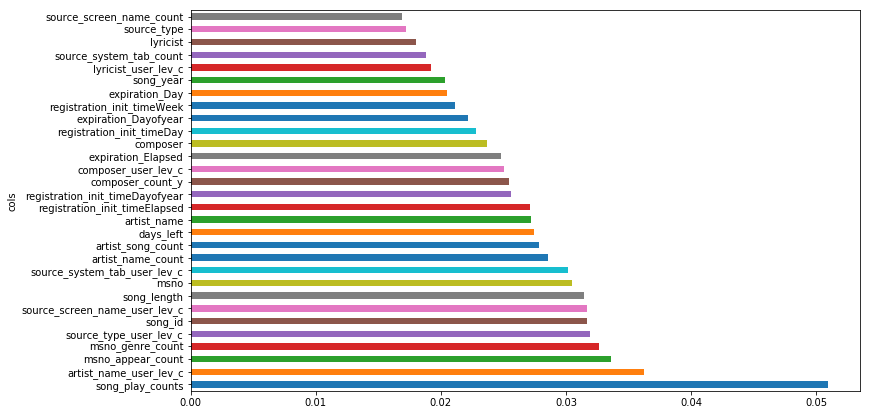

In [15]:
def plot_fi(fi):return fi.plot('cols', 'imp', 'barh', 
                               figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [16]:
to_keep = fi[fi.imp>0.015].cols; len(to_keep)

32

In [17]:
X_train_sampled = X_train_sampled[to_keep]
X_val = X_val[to_keep]
X_test = X_test[to_keep]
X_train = X_train[to_keep]

#### 3.4 Grid Search

In [18]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', RandomForestClassifier(n_jobs=-1))]) 

grid_params = dict(clf__n_estimators = [50,100,150,200],
                  clf__max_features = ['sqrt', 'log2'],
                  clf__min_samples_split = [2,10,20])

gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

'0.6673'

In [19]:
# Best algorithm with best hyperparameters 
# need to fit it to find specific model parameters
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
gs.best_estimator_.get_params()['clf']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
m = RandomForestClassifier(n_estimators=100, n_jobs=-1,oob_score=False,
                           max_features='sqrt', min_samples_split= 2)
m.fit(X_train, y_train)
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.75


In [22]:
# Test accuracy
predicted = m.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.751


# 4. Evaluation Metric

#### 4.1 Prediction Score

In [23]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.74912559 0.75240482]
recall: [0.74834282 0.75317912]
fscore: [0.748734   0.75279177]
support: [732119 743365]


#### 4.2 Confusion Matrix

Confusion matrix, without normalization
[[547876 184243]
 [183478 559887]]
Normalized confusion matrix
[[0.75 0.25]
 [0.25 0.75]]


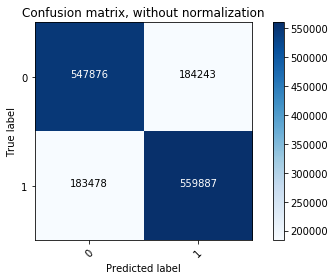

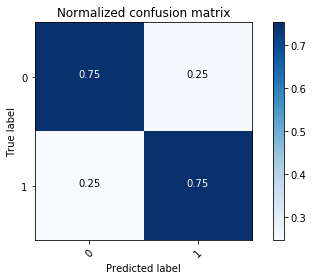

In [24]:
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [25]:
pd.DataFrame(predicted, columns=['rf']
            ).to_csv('rf_test_score.csv',index=False)

#### 4.3 ROC Curve

In [26]:
# Predict probability for ROC curve
predicted = m.predict_proba(X_test)

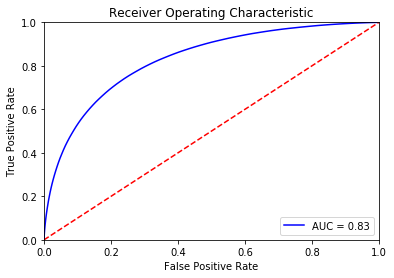

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1] for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
